# Trabalho Final PDI - Pré-Processamento 

In [ ]:
import numpy as np
from imutils import paths
import cv2 as cv
import os
from PIL import Image
import argparse

## Remove Imagens Duplicadas

In [ ]:
#script rodado no VSCODE
# comparamos as imagens com uma representação numerica imagens com o mesmo hash sao consideradas duplicadas 
def hash(image, hashSize = 8):

    cinza = cv.cvtColor(image, cv.COLOR_BGR2GRAY) #rgb para cinza
    resize = cv.resize(cinza, (hashSize + 1,  hashSize)) #redimensiona com hashSize = 8 
    
    diff = resize[:, 1:] > resize[:, :-1] #diferença de imagem pelo gradiente horizontal relativo entre os pixels 
    
    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v]) #retorna o calculo do hash 

#sistema de linha de comando
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", required=True, help="Path to input dataset")
ap.add_argument("-r", "--remove", type=int, default=-1, help="deseja remover duplicas?")
args= vars(ap.parse_args())



#input diretorio do dataset
print("[INFO] computing image hashes...")
imagePaths = list(paths.list_images(args["dataset"]))
hashes = {}

for imagePath in imagePaths:
    image = cv.imread(imagePath)
    h = hash(image)

    p=hashes.get(h, [])
    p.append(imagePath)
    hashes[h] = p

for (h, hashedPaths) in hashes.items():

    if len(hashedPaths) > 1:
        if args["remove"] <= 0:
            montage = None

            for p in hashedPaths:
                image = cv.imread(p)
                image = cv.resize(image, (150, 150))

                if montage is None:
                    montage = image
                else:
                    montage = np.hstack([montage, image])
            
            print("[INFO] hash: {}".format(h))
            cv.imshow("Montage", montage)
            cv.waitKey(0)
    else:
        for p in hashedPaths[1:]:
            os.remove(p)

## Converte .PNG para JPG

In [ ]:
png = glob('Teste/fibrosa/*.png')
for i in png:
    im = cv.imread(i)
    cv.imwrite(i[:-3] + 'jpg', im)

## Remove arquivos que nao tem extensao .JPEG

In [ ]:
#path treino
folder_path = 'Treino'
extensions = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        file_path = os.path.join(sub_folder_path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        im = Image.open(file_path)
        rgb_im = im.convert('RGB')
        if filee.split('.')[1] not in extensions:
            extensions.append(filee.split('.')[1])

In [ ]:
#path valida
folder_path = 'Valida' ##Valida e Teste
extensions = []
for filee in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filee)
    print('** Path: {}  **'.format(file_path), end="\r", flush=True)
    im = Image.open(file_path)
    rgb_im = im.convert('RGB')
    if filee.split('.')[1] not in extensions:
        extensions.append(filee.split('.')[1])

# Trabalho Final PDI - Treinamento e Teste

## Import das bibliotecas necessarias para o projeto

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
import io
import tensorflow as tf
import pathlib
import glob as glob
import cv2 as cv
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Seta a base de treino

In [5]:
df = "Treino"
df = pathlib.Path(df)

## Analise dos Dados

In [6]:
#conta quantas imagens temos no path
image_count = len(list(df.glob('*/*.jpg')))
print(image_count)

937


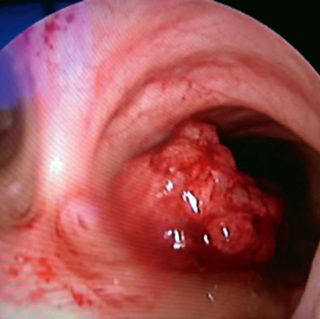

In [7]:
#mostra imagem de exemplo da classe 1
Carcinoma = list(df.glob('Carcinoma/*'))
PIL.Image.open(str(Carcinoma[0]))

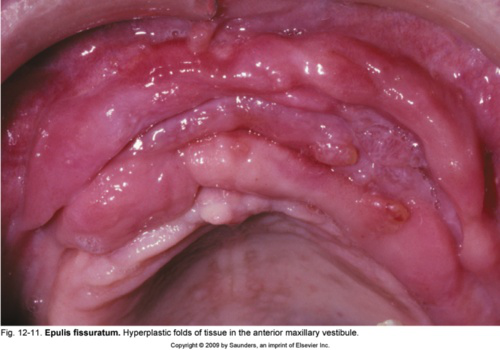

In [8]:
#mostra imagem de exemplo da classe 2
Fibrosa = list(df.glob('Hiperplasia_Fibrosa/*'))
PIL.Image.open(str(Fibrosa[0]))

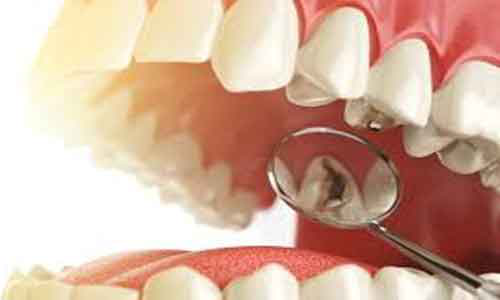

In [9]:
#mostra imagem de exemplo da classe 2
Carie = list(df.glob('Carie/*'))
PIL.Image.open(str(Carie[0]))

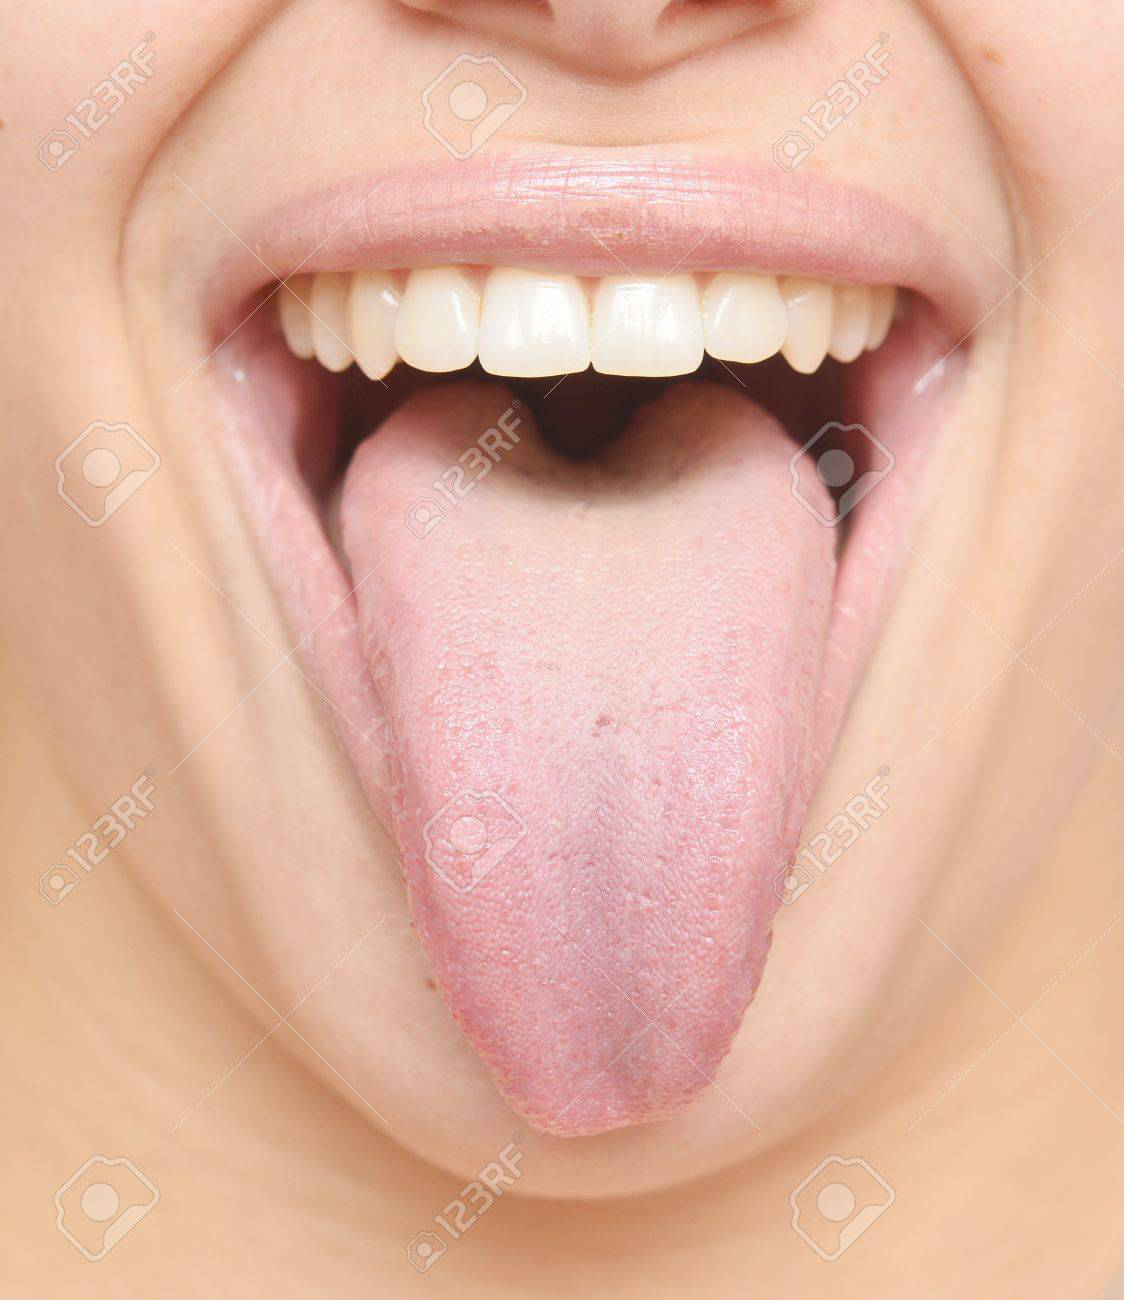

In [10]:
#mostra imagem de exemplo da classe 3
Normal = list(df.glob('Normal/*'))
PIL.Image.open(str(Normal[0]))

## Vamos definir alguns parametros para os dados e a rede neural

In [11]:
batch_size = 32  #dividimos o treinamento em lotes de 32 imagens 
img_height = 180 #padronizamos a altura das imagens em 180px
img_width = 180  #padronizamos a largura das imagens em 180px

## Agora dividiremos os dados em treino e validação 

In [12]:
#Pegamos 80% das imagens para treino 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  df,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1045 files belonging to 4 classes.
Using 836 files for training.


In [13]:
#Pegamos 20% das imagens para validação
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  df,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1045 files belonging to 4 classes.
Using 209 files for validation.


In [14]:
#podemos observar as classes do problema
class_names = train_ds.class_names
print(class_names)

['Carcinoma', 'Carie', 'Hiperplasia_Fibrosa', 'normal']


## Amostra das Imagens

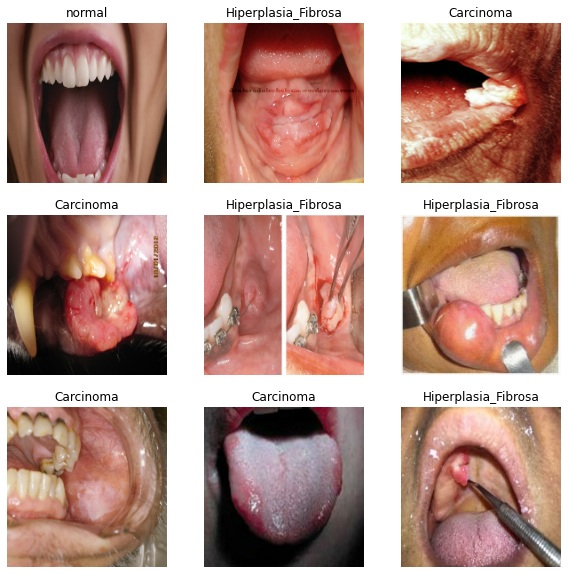

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    

## Melhorando o Desempenho 

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) 
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Padronização dos Dados

In [19]:
#passando as cores de um intervalo [0, 255] para [0, 1]
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [33]:
#podemos observar o novo intervalo de cores
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Criação do Modelos

In [28]:
num_classes = 4 #umero de classes do problema

#temos 3 blocos de convolução, todas as camadas são ativadas relu 
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255), 
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compilando o Modelo

In [29]:
#para a metrica de avaliação usaremos acurácia 
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Treinamento 

In [30]:
#usaremos primeiramente 10 epocas para o treinamento do model e analisaremos os resultados
epochs=9
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/9
27/27 [==============================] - 9s 341ms/step - loss: 1.4896 - accuracy: 0.4187 - val_loss: 1.1139 - val_accuracy: 0.5072
Epoch 2/9
27/27 [==============================] - 9s 344ms/step - loss: 1.0587 - accuracy: 0.5873 - val_loss: 0.9502 - val_accuracy: 0.6459
Epoch 3/9
27/27 [==============================] - 9s 330ms/step - loss: 0.9025 - accuracy: 0.6519 - val_loss: 0.8112 - val_accuracy: 0.6986
Epoch 4/9
27/27 [==============================] - 9s 320ms/step - loss: 0.7018 - accuracy: 0.7261 - val_loss: 0.8107 - val_accuracy: 0.6842
Epoch 5/9
27/27 [==============================] - 9s 319ms/step - loss: 0.5866 - accuracy: 0.7883 - val_loss: 0.8062 - val_accuracy: 0.6986
Epoch 6/9
27/27 [==============================] - 9s 319ms/step - loss: 0.5268 - accuracy: 0.8218 - val_loss: 0.7424 - val_accuracy: 0.7177
Epoch 7/9
27/27 [==============================] - 9s 340ms/step - loss: 0.3770 - accuracy: 0.8660 - val_loss: 0.7821 - val_accuracy: 0.7225
Epoch 8/9
27/

## Resultado Visual Do Treinamento

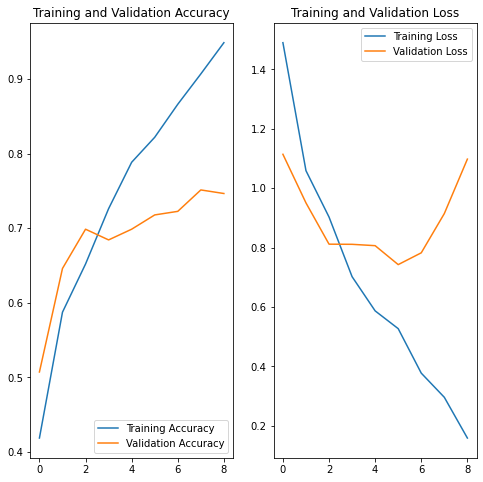

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Tentativa de Melhora dos Dados (Preprocessamento)

In [21]:
#aumentaremos os dados de treinamento rotacionando as imagens ja existentes na base
aumento_dados = keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),]

)

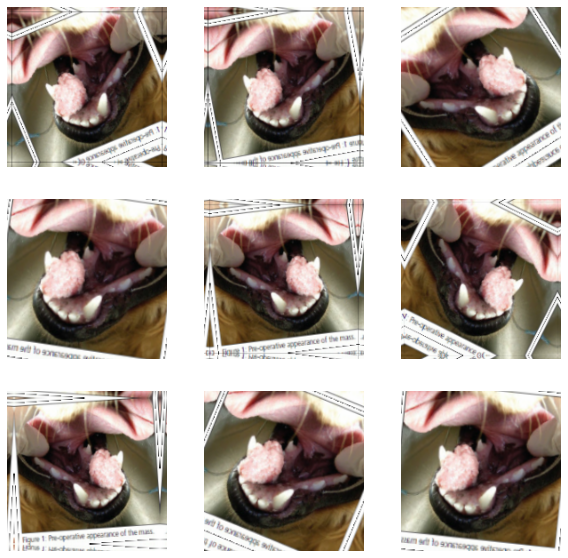

In [22]:
#Podemos ver uma das imagens copiada em diferentes sentidos
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = aumento_dados(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Segundo treinamento da REDE

In [23]:
#treinaremos a rede novamente agora com os aumentos dos dados
model = Sequential([
  aumento_dados,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Segundo Treinamento

In [25]:
#aumentamos também o numero de epocas 
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
27/27 [==============================] - 11s 413ms/step - loss: 1.3082 - accuracy: 0.4079 - val_loss: 1.1524 - val_accuracy: 0.6220
Epoch 2/15
27/27 [==============================] - 11s 426ms/step - loss: 1.1574 - accuracy: 0.4988 - val_loss: 1.0596 - val_accuracy: 0.5789
Epoch 3/15
27/27 [==============================] - 12s 444ms/step - loss: 1.0466 - accuracy: 0.5646 - val_loss: 0.8878 - val_accuracy: 0.6603
Epoch 4/15
27/27 [==============================] - 11s 397ms/step - loss: 0.9315 - accuracy: 0.6160 - val_loss: 0.8445 - val_accuracy: 0.6507
Epoch 5/15
27/27 [==============================] - 10s 380ms/step - loss: 0.8868 - accuracy: 0.6447 - val_loss: 0.8928 - val_accuracy: 0.6459
Epoch 6/15
27/27 [==============================] - 10s 374ms/step - loss: 0.8726 - accuracy: 0.6627 - val_loss: 0.8111 - val_accuracy: 0.6746
Epoch 7/15
27/27 [==============================] - 10s 374ms/step - loss: 0.8038 - accuracy: 0.6794 - val_loss: 0.9461 - val_accuracy: 0.6555

## Segunda Avaliação do Treinamento

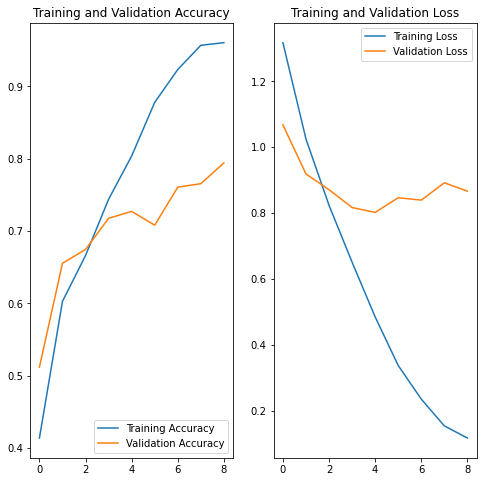

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Previsão Com Imagens de Teste

In [39]:
caminho_imagem = "Teste/Fibrosa/1.jpg"

img = keras.preprocessing.image.load_img(
   caminho_imagem, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Crate a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Esta Imagem Pertence a Classe {} com uma confiança de {:.2f}%."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Esta Imagem Pertence a Classe Carie com uma confiança de 47.93%.
